# Lower Back Pain Predictor

In [1]:
## Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,  precision_score, roc_curve, auc, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import time

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preprocessing

In [2]:
# Load Data
data = pd.read_csv('Dataset.csv')

# Encode output
label_encoder = LabelEncoder()
data['Label'] = data['Label'].map({'Normal': 0, 'Abnormal': 1})


# Seperate target and inputs
X = data.drop('Label', axis=1)
y = data['Label']


# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Observations
observations = X_train.shape[0]

# Observations for each class
class_obs = y_train.value_counts()

# Z-standardizing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Neural Network Model (Torch)

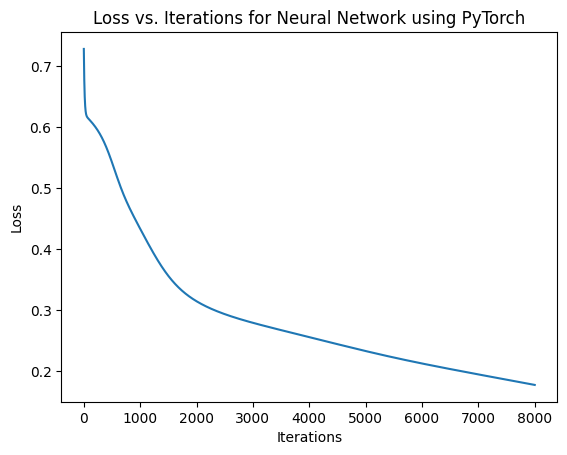

In [3]:

# Define the neural network
class NN_model(torch.nn.Module):
    def __init__(self, input_size):
        super(NN_model, self).__init__()

        # First hidden layer
        self.linear1 = torch.nn.Linear(input_size, 100)
        self.logsigmoid1 = torch.nn.LogSigmoid()
        # Second hidden layer
        self.linear2 = torch.nn.Linear(100, 60)
        self.logsigmoid1 = torch.nn.LogSigmoid()
        # Output layer with 2 units
        self.linear3 = torch.nn.Linear(60, 2)
        self.logsigmoid3 = torch.nn.LogSigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.logsigmoid1(x)
        x = self.linear2(x)
        x = self.logsigmoid3(x)
        x = self.linear3(x)
        x = self.logsigmoid3(x)
        return x

# Initialize the model
input_size = X_train_scaled.shape[1]
model = NN_model(input_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)

# Train
losses = []
start_time = time.time()
for i in range(8000):
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
end_time = time.time()
training_time = (end_time - start_time) * 1000

# Plotting the loss
plt.figure()
plt.plot(range(8000), losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations for Neural Network using PyTorch') 
plt.show()

### Testing

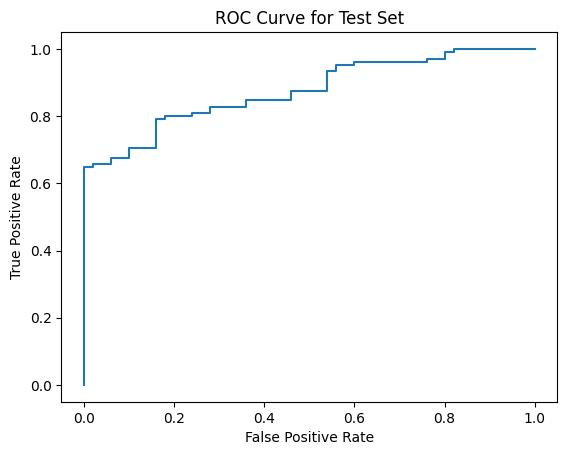

ROC Area Under Curve: 0.88
Precision: 0.83
Recall: 0.83
F1-Score: 0.83
Training time: 11815.65
Test time: 2.01


In [4]:
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

# Make predictions
start_time = time.time()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_test = torch.argmax(y_pred_test, axis=1).detach().numpy()
    y_prob_test = torch.nn.functional.softmax(model(X_test_tensor), dim=1)
    y_prob_pos = y_prob_test[:,1].detach().numpy()
end_time = time.time()

precision = precision_score(y_test_tensor, y_pred_test)
recall = recall_score(y_test_tensor, y_pred_test)
f1 = f1_score(y_test_tensor, y_pred_test)

test_time = (end_time - start_time) * 1000


fpr, tpr, thresholds = roc_curve(y_test, y_prob_pos )
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.show()

print("ROC Area Under Curve: %.2f" % roc_auc)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F1-Score: %.2f" % f1)
print("Training time: %.2f" % training_time)
print("Test time: %.2f" % test_time)